In [1]:
%matplotlib inline


# Eddy detection

Script will detect eddies on adt field, and compute u,v with method add_uv(which could use, only if equator is avoid)

Figures will show different step to detect eddies.

https://www.youtube.com/watch?v=44fsoeh9sc8


In [2]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.eddy_feature import Contours
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as Path
import xarray as xr

In [3]:
date = datetime(2016, 6, 1)
extent = [200, 240, 42, 62]

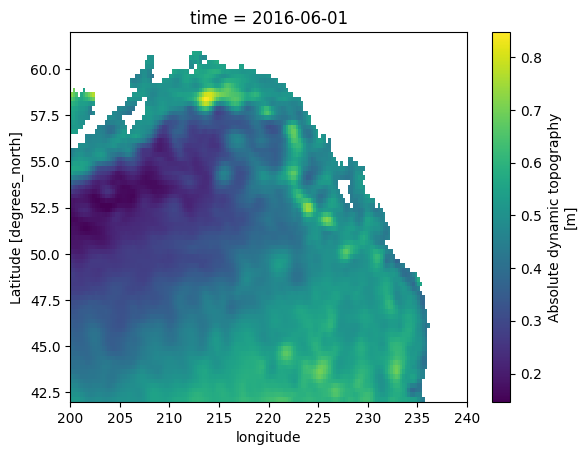

In [4]:
ds=xr.open_dataset('~/project36/obs/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2016.nc')
ds1=ds.sel(time=date,method='nearest')
x=ds['longitude']+360
ds1['longitude']=x
ds2=ds1.sel(longitude=slice(extent[0],extent[1])).sel(latitude=slice(extent[2],extent[3]))
ds2.to_netcdf('ssh.nc')
ds2=xr.open_dataset('ssh.nc')
ds2.adt.plot()

In [5]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_xlim(200, 240), ax.set_ylim(42, 62)
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

Load Input grid, ADT is used to detect eddies



We assume pixel position of grid is centered for ssh.nc


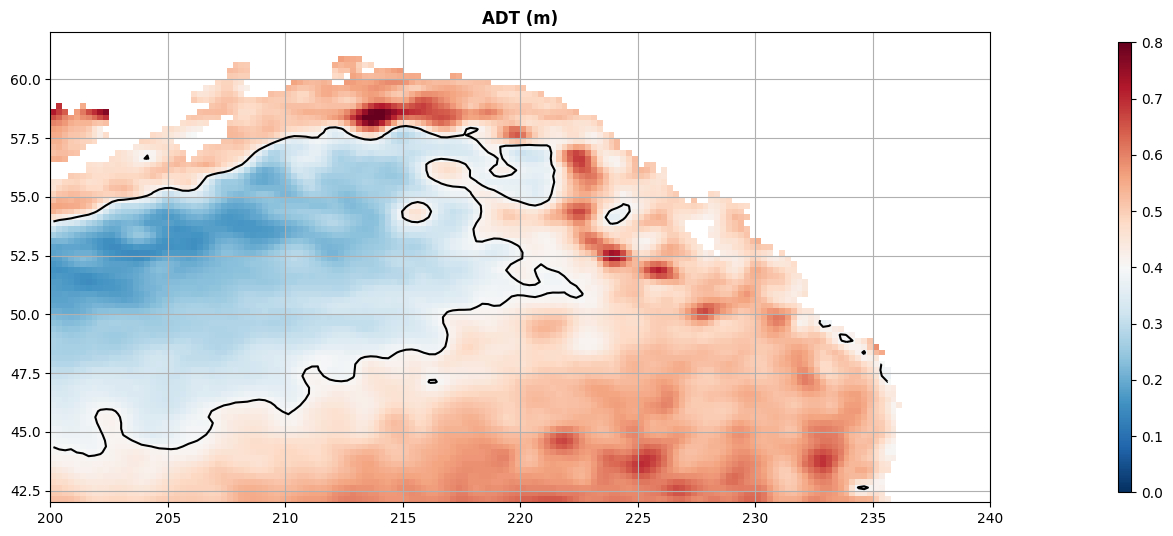

In [6]:
margin = 30
g = RegularGridDataset(
    "ssh.nc",
    "longitude",
    "latitude",
    nan_masking=True,)

ax = start_axes("ADT (m)")
m = g.display(ax, "adt", vmin=0, vmax=.8, cmap="RdBu_r")
great_current = Contours(g.x_c, g.y_c, g.grid("adt"), levels=(0.4,), keep_unclose=True)
great_current.display(ax, color="k")
update_axes(ax, m)

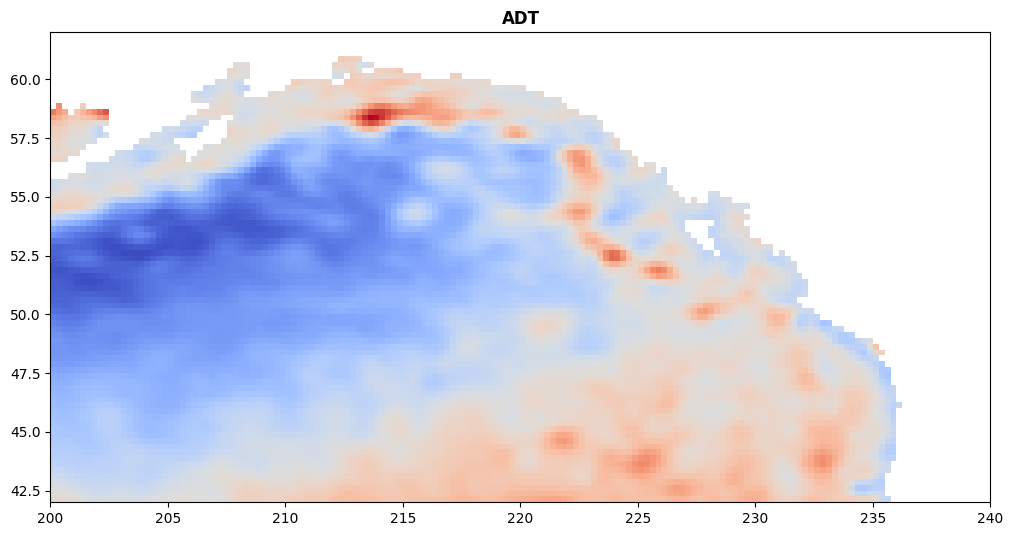

In [7]:
ax=start_axes('ADT')
g.display(ax,'adt')

## Get geostrophic speed u,v
U/V are deduced from ADT, this algortihm is not ok near the equator (~+- 2°)



In [8]:
g.add_uv("adt")

## Pre-processings
Apply a high-pass filter to remove the large scale and highlight the mesoscale



In [9]:
g.bessel_high_filter("adt", 700)

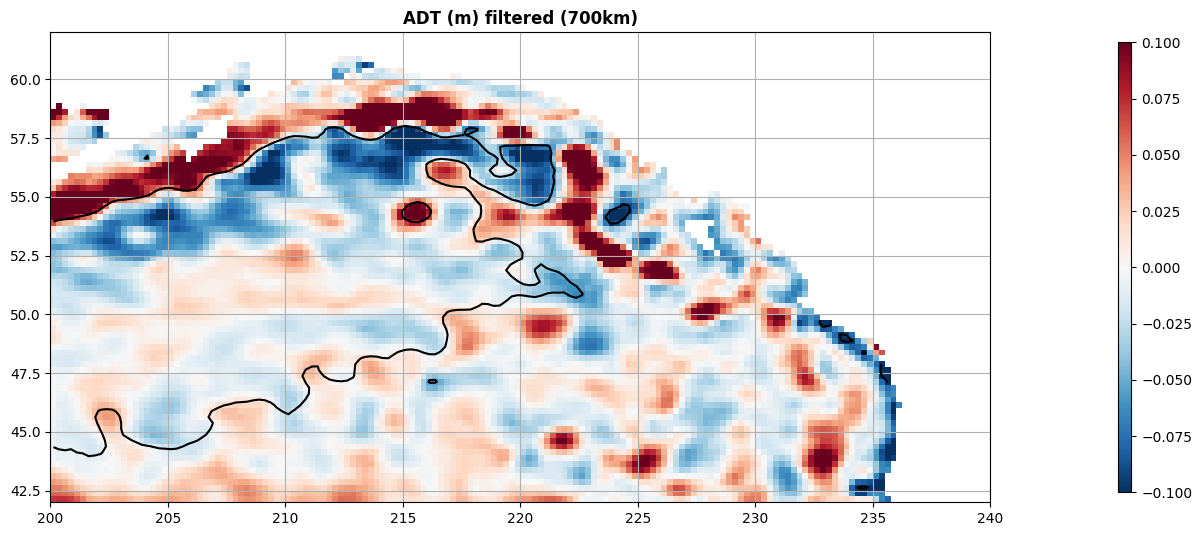

In [10]:
ax = start_axes("ADT (m) filtered (700km)")
m = g.display(ax, "adt", vmin=-0.1, vmax=0.1, cmap="RdBu_r")
great_current.display(ax, color="k")
update_axes(ax, m)

## Identification
Run the identification step with slices of 2 mm



In [11]:
date = datetime(1993, 1, 15)
a, c = g.eddy_identification("adt", "u", "v", date, 0.002, shape_error=55)

/glade/work/ito/miniconda3/envs/REU-2023b/lib/python3.10/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Display of all closed contours found in the grid (only 1 contour every 5)



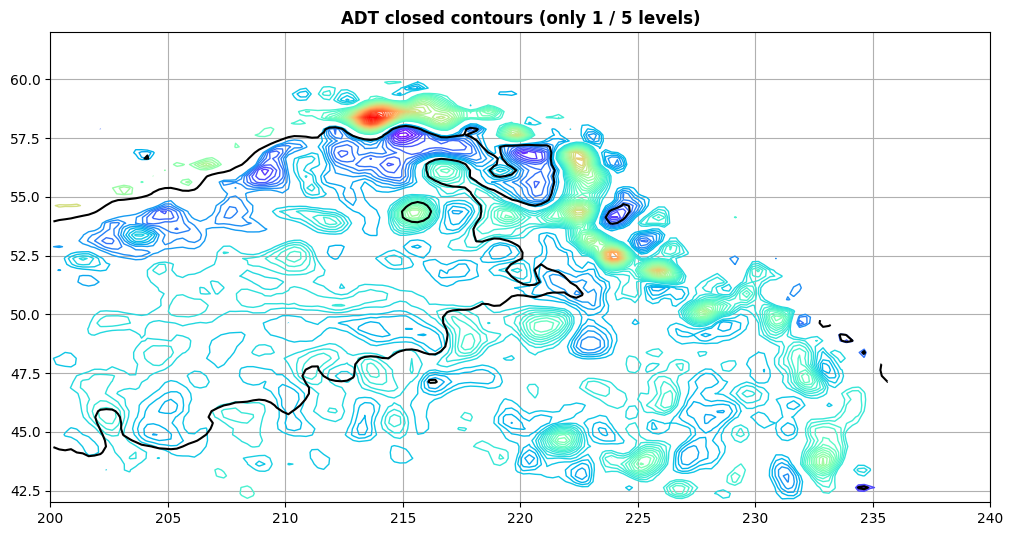

In [12]:
ax = start_axes("ADT closed contours (only 1 / 5 levels)")
g.contours.display(ax, step=5, lw=1)
great_current.display(ax, color="k")
update_axes(ax)

Contours included in eddies



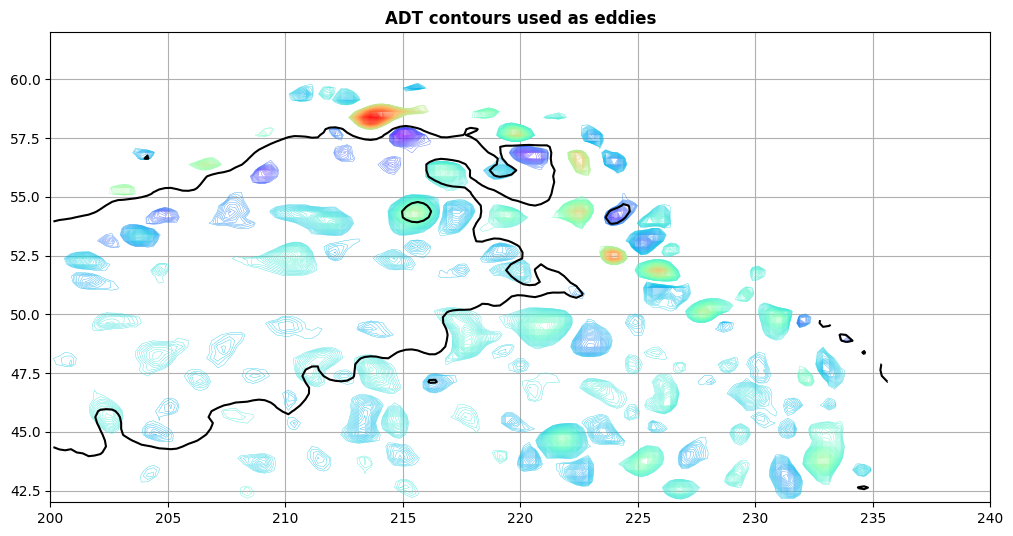

In [13]:
ax = start_axes("ADT contours used as eddies")
g.contours.display(ax, only_used=True, lw=0.25)
great_current.display(ax, color="k")
update_axes(ax)

## Post analysis
Contours can be rejected for several reasons (shape error to high, several extremum in contour, ...)



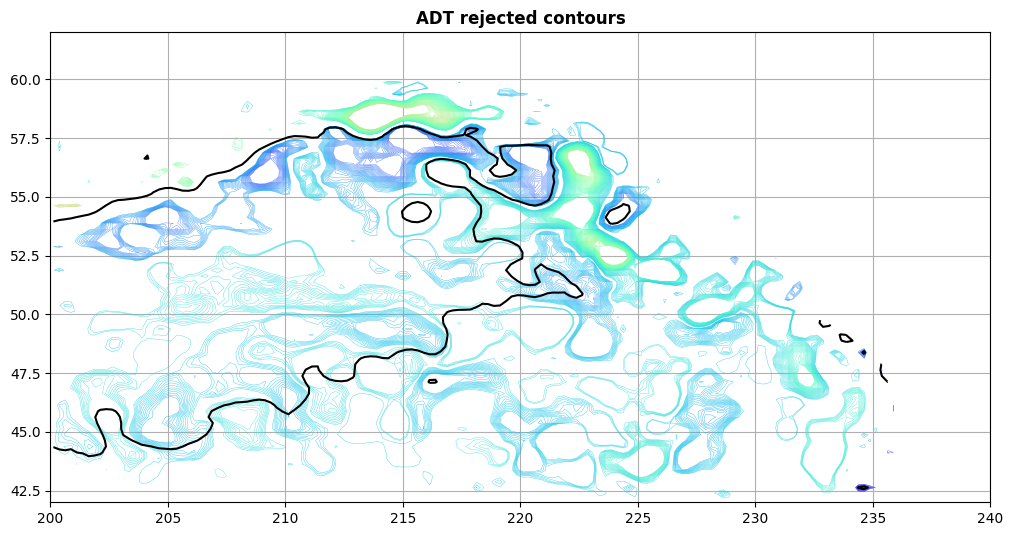

In [14]:
ax = start_axes("ADT rejected contours")
g.contours.display(ax, only_unused=True, lw=0.25)
great_current.display(ax, color="k")
update_axes(ax)

Criteria for rejecting a contour :
 0. Accepted (green)
 1. Rejection for shape error (red)
 2. Masked value within contour (blue)
 3. Under or over the pixel limit bounds (black)
 4. Amplitude criterion (yellow)



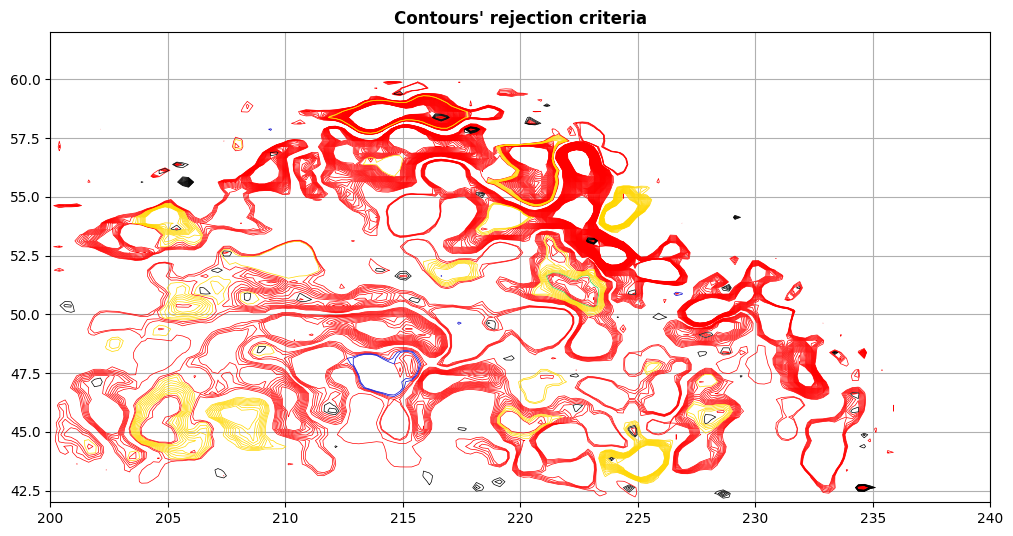

In [15]:
ax = start_axes("Contours' rejection criteria")
g.contours.display(ax, only_unused=True, lw=0.5, display_criterion=True)
update_axes(ax)

Display the shape error of each tested contour, the limit of shape error is set to 55 %



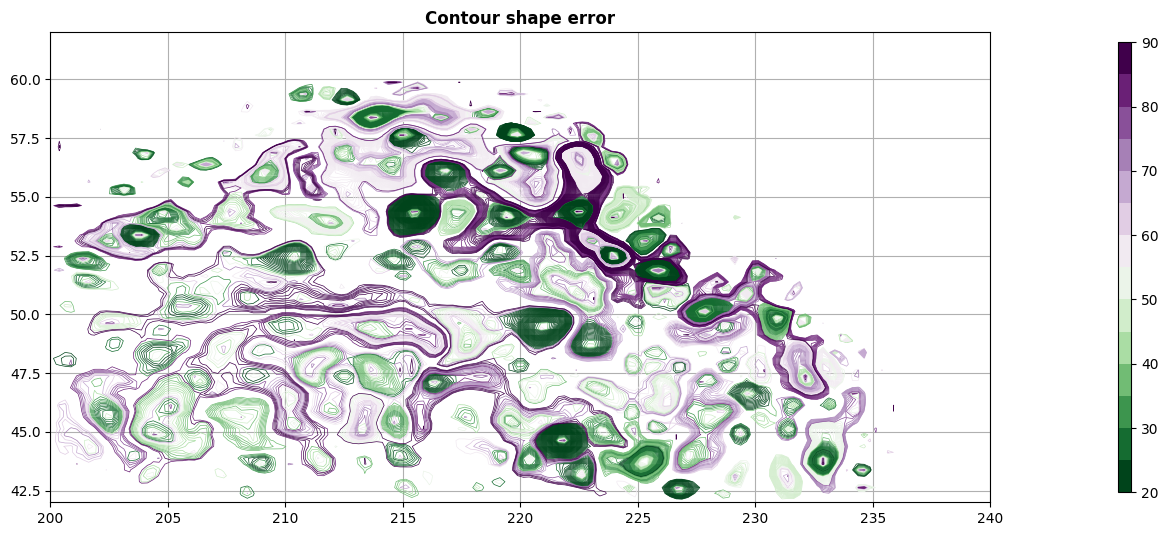

In [16]:
ax = start_axes("Contour shape error")
m = g.contours.display(
    ax, lw=0.5, field="shape_error", bins=arange(20, 90.1, 5), cmap="PRGn_r"
)
update_axes(ax, m)

Some closed contours contains several eddies (aka, more than one extremum)



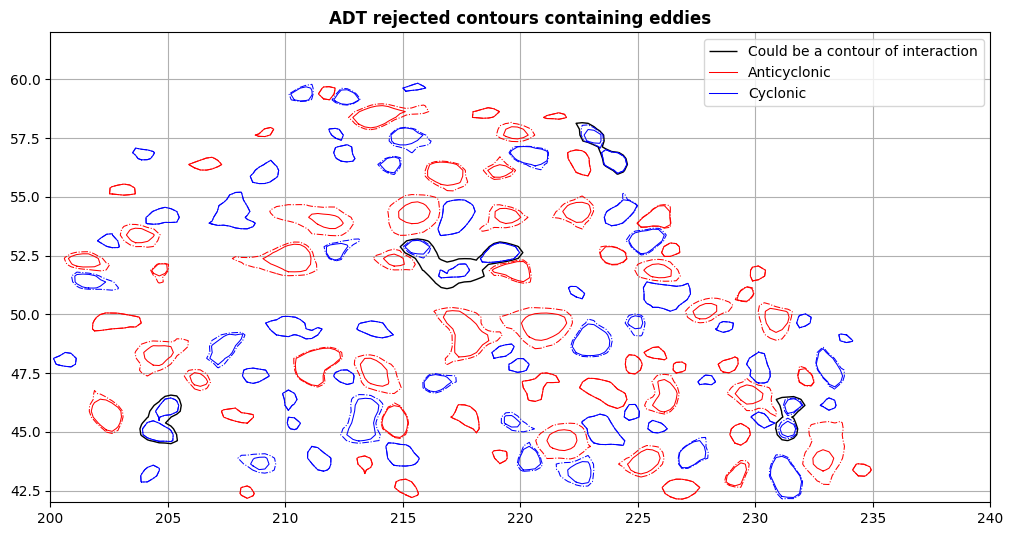

In [17]:
ax = start_axes("ADT rejected contours containing eddies")
g.contours.label_contour_unused_which_contain_eddies(a)
g.contours.label_contour_unused_which_contain_eddies(c)
g.contours.display(
    ax,
    only_contain_eddies=True,
    color="k",
    lw=1,
    label="Could be a contour of interaction",
)
a.display(ax, color="r", linewidth=0.75, label="Anticyclonic", ref=-10)
c.display(ax, color="b", linewidth=0.75, label="Cyclonic", ref=-10)
ax.legend()
update_axes(ax)

## Output
When displaying the detected eddies, dashed lines are for effective contour, solide lines for the contour of the
maximum mean speed. See figure 1 of https://doi.org/10.1175/JTECH-D-14-00019.1



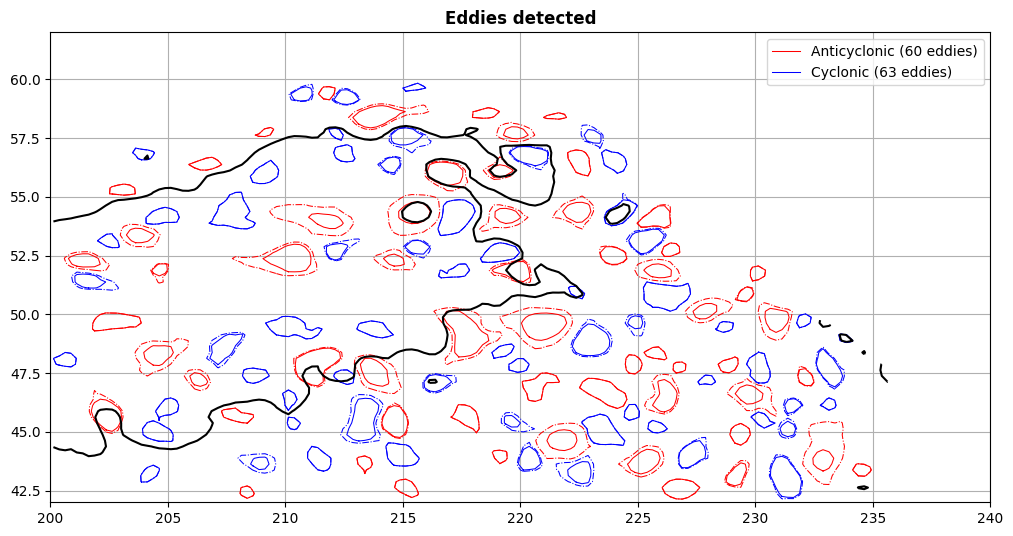

In [18]:
ax = start_axes("Eddies detected")
a.display(
    ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-10
)
c.display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-10)
ax.legend()
great_current.display(ax, color="k")
update_axes(ax)

Display the effective radius of the detected eddies



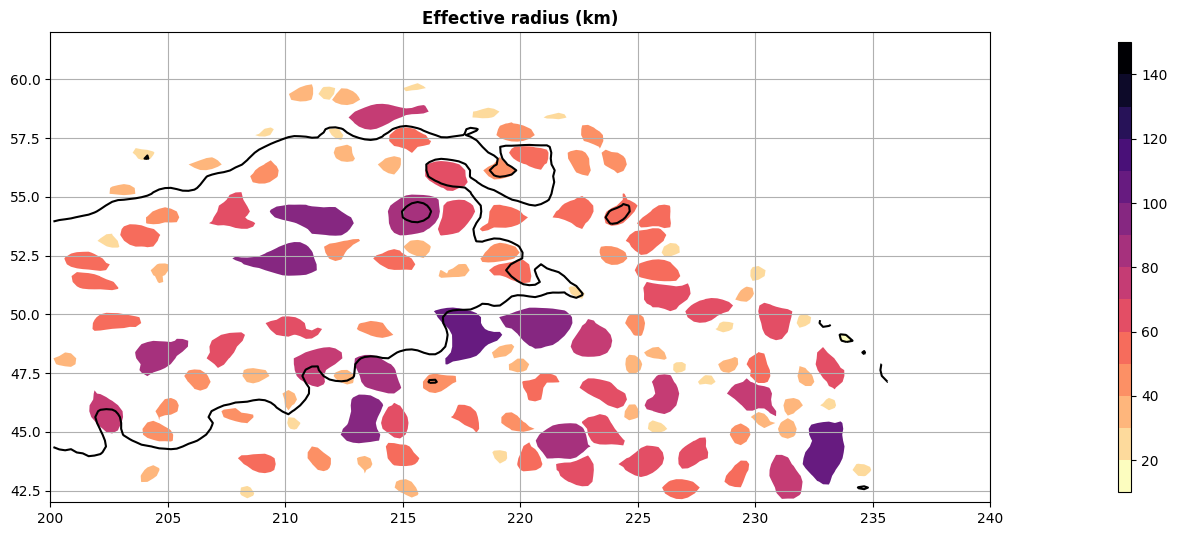

In [19]:
ax = start_axes("Effective radius (km)")
a.filled(ax, "radius_e", vmin=10, vmax=150, cmap="magma_r", factor=0.001, lut=14)
m = c.filled(ax, "radius_e", vmin=10, vmax=150, cmap="magma_r", factor=0.001, lut=14)
great_current.display(ax, color="k")
update_axes(ax, m)